In [1]:
# Reading spatial files

import glob
import os
import pandas as pd
import math
from scipy.stats import zscore
from mpl_toolkits.axes_grid1 import AxesGrid
import scipy
import matplotlib.pyplot as plt

bins=16 # number of bins in the heatmap 16*16 = 256

CM = 11 # conversion variable 1 cm is equal to 11 pxl
STIMULUS = 1 # collects positions only during stimulus presentation
INTERSTIMULUS = 2 # collects positions only during interstimulus intervals
ALL = 3 # collects every data point

pval = lambda x: 1 - scipy.special.ndtr(x)

# date parser
def prsf(x):
    return float(x)
def prsi(x):
    return int(x)

def prse(x):
    if x == '0':
        return 'None'
    else:
        return x

# convert txt files to pandas
def reader(filename):
    df = pd.read_csv(filename, sep='\t', lineterminator='\n',header=1,
                converters={0:prsf,1:prsi,2:prsi,3:prse},usecols=[0,1,2,3],
                names=['time','x','y','event'])
    df['dist'] = list(map(math.sqrt,(df['x'].diff()**2 + df['y'].diff()**2).values))
    df = df.drop(df[df['dist']>100].index) # artifact rejection
    deltaT = df['time'].diff()
    df['speed'] = df['dist'] / deltaT
    return df

# converts raw positions to heatmaps [ heatmaps are flat pandas rows with bins*bins columns]
def heatmap(df,bins=16,norm=1,flat=1,event=ALL):
    df['dist'] = list(map(math.sqrt,(df['x'].diff()**2 + df['y'].diff()**2).values))
    df = df.drop(df[df['dist']>100].index) # artifact rejection
    if event is STIMULUS:
        df = df[df['event'] != 'None']
    elif event is INTERSTIMULUS:
        df = df[df['event'] == 'None']
    
    hist2,x,y = np.histogram2d( df['x'].values,df['y'].values,bins=(bins,bins) )
    if flat==1:
        hist2=np.reshape(hist2,[-1])
    if norm==1:
        hist2 = zscore(hist2)
    return hist2

# calculates average velocity and distance 
def dist_speed(df,event=ALL):
    df['dist'] = list(map(math.sqrt,(df['x'].diff()**2 + df['y'].diff()**2).values))
    df = df.drop(df[df['dist']>100].index ) # artifact rejection
    
    if event is STIMULUS:
        df = df[df['event'] != 'None']
    elif event is INTERSTIMULUS:
        df = df[df['event'] == 'None']
        
    totDistance = df['dist'].sum()
    deltaT = df['time'].diff()
    df['speed'] = df['dist'] / deltaT
    avgSpeed = df['speed'].mean()
    return avgSpeed,totDistance


# example
#path = os.getcwd() + '/data_track/F-0R0-WT/20180117_1121-tracker-F0R0.txt'
#df = reader(path)
#heatmap(df,bins=bins)
#dist_speed(df)

In [2]:
# reading heatmaps of all animals and all days
# The info of the animal are stored in the folder name 
# [e.g. F-0R0-WT means cage:F label:0R0 genotype:wild type. The parser split using '-' token]

path = os.getcwd() + '/data_track/' # replace with data folder directory
bins = 16
hm = pd.DataFrame(columns=['day','geno','label','cage'] + ['col_' + str(p) for p in range(bins**2)])

cf=glob.glob(os.path.join(path, "*/"))
print('Loading heatmaps...')
for s in cf:
    chi = os.path.basename(os.path.normpath(s))
    res = chi.split('-')
    cage=res[0]
    label=res[1]
    geno=res[2]
    inc = 1

    content=glob.glob(os.path.join(s, "*.txt"))
    for f in content:
        filename = f
        df = reader(filename)
        tmphm = heatmap(df,bins=bins,event=STIMULUS)
        temp_interstim = heatmap(df,bins=bins,event=INTERSTIMULUS)
        temp=list()
        
        temp.append(inc)
        temp.append(geno)
        temp.append(label)
        temp.append(cage)
        
        [temp.append(t) for t in tmphm]
        
        hm.loc[len(hm)]=temp
        inc=inc+1
        
hm.head()


Loading heatmaps...


,day,geno,label,cage,col_0,col_1,col_2,col_3,col_4,col_5,...,col_246,col_247,col_248,col_249,col_250,col_251,col_252,col_253,col_254,col_255
0,1,WT,R00,F,-0.559681,-0.505099,0.095306,-0.559681,-0.123023,-0.395934,...,-0.341352,-0.177606,-0.013859,0.531964,-0.341352,0.586546,-0.177606,2.879000,-0.559681,0.095306
1,2,WT,R00,F,-0.465580,-0.465580,0.922961,0.083378,-0.271830,-0.433289,...,-0.142664,-0.400997,0.083378,-0.465580,-0.465580,-0.433289,-0.336414,-0.433289,-0.336414,-0.271830
2,3,WT,R00,F,0.698507,-0.563508,-0.660586,0.407273,0.310195,1.378054,...,-0.272274,-0.563508,-0.272274,-0.272274,-0.369352,-0.369352,-0.369352,0.504351,1.475132,4.581631
3,4,WT,R00,F,-0.430175,-0.430175,-0.430175,-0.168596,0.616141,-0.364780,...,0.289167,-0.037806,0.289167,-0.103201,-0.299385,-0.103201,0.092983,2.512588,4.866799,2.643378
4,5,WT,R00,F,-0.587766,-0.587766,-0.117920,-0.470305,-0.587766,-0.587766,...,-0.529035,-0.587766,-0.529035,-0.587766,-0.529035,-0.587766,-0.470305,1.702732,1.174156,1.644002


In [4]:
# reading distance and speed of all animals and all days

path = os.getcwd()+ '/data_track/' # replace with data folder directory
bins = 16
ds = pd.DataFrame(columns=['day','geno','label','cage','speed','dist'])

cf=glob.glob(os.path.join(path, "*/"))
print('Loading distance and speed...')
for s in cf:
    chi = os.path.basename(os.path.normpath(s))
    res = chi.split('-')
    cage=res[0]
    label=res[1]
    geno=res[2]
    inc = 1

    content=glob.glob(os.path.join(s, "*.txt"))
    for f in content:
        filename = f
        df = reader(filename)
        speedist = dist_speed(df,event=ALL)
        temp2=list()
        temp2.append(inc)
        temp2.append(geno)
        temp2.append(label)
        temp2.append(cage)
        [temp2.append(t) for t in speedist]
        ds.loc[len(ds)]=temp2
        inc=inc+1

ds['speed'] = ds['speed']/CM # conversion in cm/sec
ds['dist'] = ds['dist']/CM # conversion in cm
#ds.to_csv('speed_dist.csv')
ds.head()

Loading distance and speed...


,day,geno,label,cage,speed,dist
0,1,WT,R00,F,5.104530,2032.073703
1,2,WT,R00,F,3.846427,2341.800624
2,3,WT,R00,F,4.521653,2070.035231
3,4,WT,R00,F,5.391709,1937.521442
4,5,WT,R00,F,4.117158,2547.291406


In [5]:
# reading heatmaps of all animals and all days klòkòl
path = os.getcwd() + '/data_track/' # replace with data folder directory

bins = 16
hm = pd.DataFrame(columns=['day','code','geno','label','cage'] + ['col_' + str(p) for p in range(bins**2)])

cf=glob.glob(os.path.join(path, "*/"))
print('Loading heatmaps...')
for s in cf:
    chi = os.path.basename(os.path.normpath(s))
    res = chi.split('-')
    cage=res[0]
    label=res[1]
    geno=res[2]
    inc = 1

    content=glob.glob(os.path.join(s, "*.txt"))
    for f in content:
        filename = f
        df = reader(filename)
        temp = heatmap(df,bins=bins,event=ALL)
        temp2=list()
        temp2.append(inc)
        temp2.append(geno+label+cage)
        temp2.append(geno)
        temp2.append(label)
        temp2.append(cage)
        
        [temp2.append(t) for t in temp]
        hm.loc[len(hm)]=temp2
        inc=inc+1
        
hm.head()


Loading heatmaps...


,day,code,geno,label,cage,col_0,col_1,col_2,col_3,col_4,...,col_246,col_247,col_248,col_249,col_250,col_251,col_252,col_253,col_254,col_255
0,1,WTR00F,WT,R00,F,-0.447821,0.119054,-0.331111,-0.431148,-0.464494,...,-0.364457,-0.231074,-0.381130,-0.247747,-0.447821,-0.481166,-0.397802,-0.414475,-0.464494,-0.447821
1,2,WTR00F,WT,R00,F,-0.465312,0.068045,-0.059961,0.622735,-0.390642,...,-0.294638,-0.401309,-0.187967,-0.443978,-0.358641,-0.454645,-0.379975,-0.454645,-0.209301,-0.401309
2,3,WTR00F,WT,R00,F,0.724608,2.313708,1.463724,-0.014508,-0.421022,...,-0.254721,-0.273199,0.207227,-0.476456,-0.384066,-0.531889,-0.384066,-0.476456,-0.217765,0.299616
3,4,WTR00F,WT,R00,F,0.624552,1.990928,0.143433,-0.395419,-0.202972,...,-0.510888,-0.510888,-0.510888,-0.491643,-0.510888,-0.510888,-0.510888,-0.510888,-0.472398,-0.510888
4,5,WTR00F,WT,R00,F,-0.259841,0.243423,-0.151027,-0.137425,-0.321048,...,-0.314248,-0.321048,-0.321048,-0.321048,-0.321048,-0.321048,-0.321048,-0.144226,-0.096620,-0.259841


(-0.5, 15.5, 15.5, -0.5)

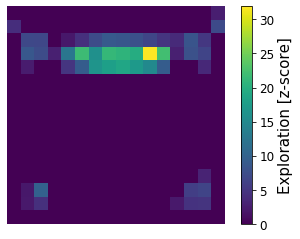

In [6]:
# average exploration significantly different from chance

# chance level for each pixel obtained from random permutation of exploration histograms
chance = pd.DataFrame(columns=['col_' + str(p) for p in range(bins**2)])
for i in range(1,100):
    chance.loc[len(chance)] = hm.iloc[:,5:].T.apply(np.random.permutation).T.mean()

# observed average exploration
obs = hm.iloc[:,5:].mean()
# zscore
z = ((obs - chance.mean())/chance.std()).values.reshape(bins,bins).T
z[abs(pval(z))>0.05]=0 # selecting only significant pixels

im = plt.imshow(z)
cb = plt.colorbar()
cb.set_label(label='Exploration [z-score]',size=15)
cb.ax.tick_params(labelsize='large')
plt.axis('off')

#plt.savefig('exploration.png',bbox_inches="tight")


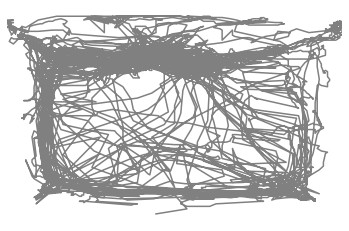

In [8]:

path = os.getcwd() + '/data_track/F-0R0-WT/20180118_0936-tracker-F0R0.txt'
df = reader(path)
df.plot(x='x',y='y',color='gray')
plt.gca().invert_yaxis()
plt.axis('off')
plt.gca().get_legend().remove()

#plt.savefig('path.png',bbox_inches="tight")

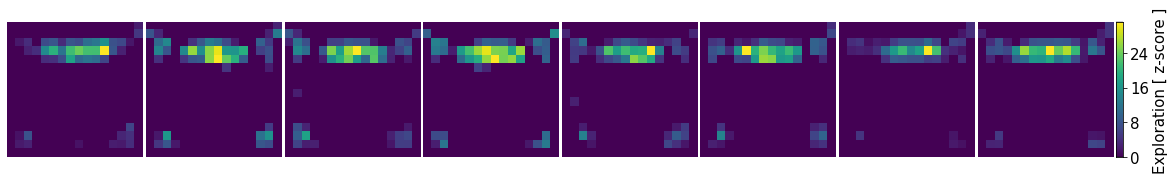

In [19]:
exp_day = hm.groupby('day').mean().reset_index()

for r in range(0,len(exp_day)):
    exp_day.iloc[r,1:] = (exp_day.iloc[r,1:]-chance.mean())/chance.std()

exp_day.iloc[:,1:][abs(pval(exp_day.iloc[:,1:]))>0.05]=0 # selecting only significant pixels


fig = plt.figure(figsize=(20,16))
grid = AxesGrid(fig, 111, 
                nrows_ncols=(1, 8), 
                axes_pad=0.05, 
                share_all=True,
                label_mode="L",
                cbar_location="right",
                cbar_mode="single",
                )

for d in exp_day['day']-1:
    temp=exp_day.iloc[d,1:].values.reshape(bins,bins).astype(float).T
    temp[pval(temp)>0.05]=0
    im=grid[d].imshow(temp)
    grid[d].axis('off')
    

cax = grid.cbar_axes[0].colorbar(im)

for cax in grid.cbar_axes:
    cax.toggle_label(True)
    cax.tick_params(labelsize=15)
    #cax.get_yaxis().set_ticks([0,20])
    cax.axis[cax.orientation].label.set_text("Exploration [ z-score ]")
    cax.axis[cax.orientation].label.set_size(15)

plt.savefig('long_expl.png',bbox_inches="tight")


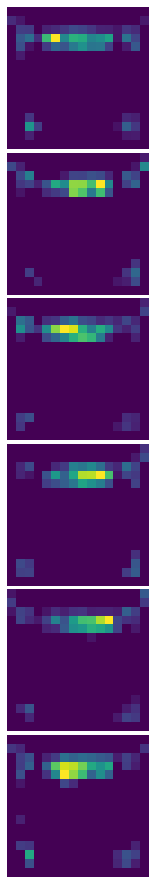

In [20]:
exp_code = hm.groupby('code').mean().reset_index()

for r in range(0,len(exp_code)):
    exp_code.iloc[r,1:] = (exp_code.iloc[r,1:]-chance.mean())/chance.std()

exp_code.iloc[:,1:][abs(pval(exp_code.iloc[:,1:]))>0.05]=0 # selecting only significant pixels


fig = plt.figure(figsize=(20,16))
grid = AxesGrid(fig, 111, 
                nrows_ncols=(6, 1), 
                axes_pad=0.05, 
                share_all=True,
                label_mode="L",
                cbar_location="right",
                cbar_mode="single",
                )

for d in range(0,6):
    temp=exp_code.iloc[d,1:].values.reshape(bins,bins).astype(float).T
    temp[pval(temp)>0.05]=0
    im=grid[d].imshow(temp)
    grid[d].axis('off')
    

cax = grid.cbar_axes[0].remove() #colorbar(im)

for cax in grid.cbar_axes:
    cax.toggle_label(True)
    cax.tick_params(labelsize=15)
    #cax.get_yaxis().set_ticks([0,20])
    cax.axis[cax.orientation].label.set_text("Exploration [ z-score ]")
    cax.axis[cax.orientation].label.set_size(15)

plt.savefig('sub_expl.png',bbox_inches="tight")

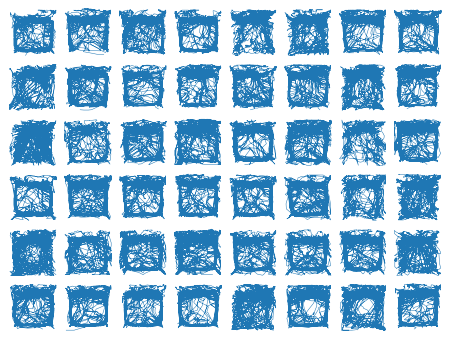

In [21]:

# reading taces of all animals and all days
path ='/Users/tardis/Documents/Jupyter/data_conditioning/data_track/'

fig = plt.figure(figsize=(16,6))
grid = AxesGrid(fig, 111, 
                nrows_ncols=(len(cf), 8), 
                axes_pad=0.05, 
                share_all=True,
                label_mode="L",
                cbar_location="right",
                cbar_mode="single",
                )

sub = 0
cf=glob.glob(os.path.join(path, "*/"))
grid[0].invert_yaxis()
for s in cf:
    chi = os.path.basename(os.path.normpath(s))
    res = chi.split('-')
    cage=res[0]
    label=res[1]
    geno=res[2]

    content=glob.glob(os.path.join(s, "*.txt"))
    for f in content:
        filename = f
        df = reader(filename)
        grid[sub].plot(df['x'],df['y'],linewidth=.5)
        grid[sub].axis('off')
        sub = sub + 1
    
    
cax = grid.cbar_axes[0].remove()

plt.savefig('long_path.png',bbox_inches="tight")
